## Importing the Packages

In [1]:
import numpy as np
import pandas as pd
from scipy.stats.distributions import chi2 
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sklearn
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from pmdarima.arima import OCSBTest 

In [2]:
import seaborn as sns
import yfinance
import warnings
warnings.filterwarnings("ignore")
sns.set()

In [3]:
from arch import arch_model
from datetime import datetime

## Importing the Data

In [4]:
raw_data = yfinance.download (tickers = "AUDUSD=X, AUDCAD=X , AUDGBP=X" , interval = "1d", group_by = 'ticker',
                              auto_adjust = True, treads = True)

[*********************100%***********************]  3 of 3 completed


In [5]:
df = raw_data.copy()
df

AUDUSD=X                                       AUDCAD=X            \
                Open      High       Low     Close Volume      Open      High   
Date                                                                            
2003-06-03       NaN       NaN       NaN       NaN    NaN       NaN       NaN   
2003-06-04       NaN       NaN       NaN       NaN    NaN       NaN       NaN   
2003-06-05       NaN       NaN       NaN       NaN    NaN       NaN       NaN   
2003-06-06       NaN       NaN       NaN       NaN    NaN       NaN       NaN   
2003-06-09       NaN       NaN       NaN       NaN    NaN       NaN       NaN   
...              ...       ...       ...       ...    ...       ...       ...   
2021-08-13  0.734020  0.738000  0.733370  0.734150    0.0  0.918810  0.923100   
2021-08-16  0.736692  0.736900  0.732032  0.736572    0.0  0.922040  0.922830   
2021-08-17  0.733920  0.733977  0.725321  0.734107    0.0  0.922530  0.922581   
2021-08-18  0.725550  0.727200  0.723160  0.725560    0.0  0.916052  0.916772   
2021-08-19  0.723668  0.724533  0.714444  0.714832    0.0  0.915130  0.917420   

                                     AUDGBP=X                             \
                Low     Close Volume     Open     High      Low    Close   
Date                                                                       
2003-06-03      NaN       NaN    NaN  0.40241  0.40669  0.40208  0.40564   
2003-06-04      NaN       NaN    NaN  0.40554  0.40809  0.40433  0.40653   
2003-06-05      NaN       NaN    NaN  0.40657  0.40728  0.39982  0.40132   
2003-06-06      NaN       NaN    NaN  0.40135  0.40334  0.39531  0.39590   
2003-06-09      NaN       NaN    NaN  0.39657  0.40092  0.39433  0.39921   
...             ...       ...    ...      ...      ...      ...      ...   
2021-08-13  0.91790  0.919086    0.0  0.53142  0.53258  0.53090  0.53150   
2021-08-16  0.91910  0.921920    0.0  0.53123  0.53123  0.52817  0.53120   
2021-08-17  0.91500  0.922348    0.0  0.53020  0.53020  0.52750  0.53008   
2021-08-18  0.91309  0.916030    0.0  0.52800  0.52872  0.52570  0.52799   
2021-08-19  0.91118  0.916710    0.0  0.52580  0.52633  0.52230  0.52406   

                   
           Volume  
Date               
2003-06-03    0.0  
2003-06-04    0.0  
2003-06-05    0.0  
2003-06-06    0.0  
2003-06-09    0.0  
...           ...  
2021-08-13    0.0  
2021-08-16    0.0  
2021-08-17    0.0  
2021-08-18    0.0  
2021-08-19    0.0  

[4724 rows x 15 columns]

## Defining Key Dates

In [6]:
# Starting Date
start_date_str = "2010-01-01" 
start_date = datetime.strptime(start_date_str,  '%Y-%m-%d').date()
print(start_date)
# approximate IMF officially recognised the CAD as a reserve currency
CAD_rc_str = "2013-06-01" 
CAD_rc=datetime.strptime(CAD_rc_str,  '%Y-%m-%d').date()
#8 novembre 2016 Trump election USD event
DT_election_str = "2016-11-08"
DT_election=datetime.strptime(DT_election_str,  '%Y-%m-%d').date()
# 31 January 2020 Brexit GBP
Brexit_str = '2020-01-31' 
Brexit=datetime.strptime(Brexit_str,  '%Y-%m-%d').date()
# ending date
end_date_str = '2021-07-01' 
end_date=datetime.strptime(end_date_str, '%Y-%m-%d').date()

2010-01-01


## Pre-processing the Data

In [7]:
# Extracting Closing Prices
df['AUDUSD=X']["Close"][start_date:end_date]
df['AUDGBP=X']["Close"][start_date:end_date]
df['AUDCAD=X']["Close"][start_date:end_date]

Date
2010-01-01    0.945120
2010-01-04    0.949400
2010-01-05    0.947300
2010-01-06    0.949000
2010-01-07    0.948700
                ...   
2021-06-25    0.934228
2021-06-28    0.932875
2021-06-29    0.933410
2021-06-30    0.931442
2021-07-01    0.929150
Name: Close, Length: 2979, dtype: float64

In [8]:
# Removing Surplus Data

x=df['AUDUSD=X'].drop( columns=["Low","High","Open","Volume"])[start_date:end_date]
y=df['AUDGBP=X'].drop( columns=["Low","High","Open","Volume"])[start_date:end_date]
z=df['AUDCAD=X'].drop( columns=["Low","High","Open","Volume"])[start_date:end_date]
#creating the new dataframe
df_new=pd.DataFrame()
df_new["AUD_USD"]=x
df_new['AUD_GBP']=y
df_new['AUD_CAD']=z
df_new

,AUD_USD,AUD_GBP,AUD_CAD
Date,,,
2010-01-01,0.898473,0.55510,0.945120
2010-01-04,0.912492,0.56619,0.949400
2010-01-05,0.911826,0.56980,0.947300
2010-01-06,0.920471,0.57422,0.949000
2010-01-07,0.917768,0.57592,0.948700
...,...,...,...
2021-06-25,0.758208,0.54477,0.934228
2021-06-28,0.759500,0.54641,0.932875
2021-06-29,0.756840,0.54527,0.933410


In [9]:
#assigning the frequency to business days
df_new = df_new.asfreq('b')
#checking for missing values 
print(df_new.isna().sum())
#filling them with the last known value
df_new = df_new.fillna(method='bfill')
#rechecking for missing values 
print(df_new.isna().sum())

AUD_USD    26
AUD_GBP    23
AUD_CAD    21
dtype: int64
AUD_USD    0
AUD_GBP    0
AUD_CAD    0
dtype: int64


In [10]:
# Creating Returns
df_new['AUD_USD_ret'] = list(df_new['AUD_USD'].pct_change(1).mul(100))
df_new['AUD_GBP_ret'] = list(df_new['AUD_GBP'].pct_change(1).mul(100))
df_new['AUD_CAD_ret'] = list(df_new['AUD_CAD'].pct_change(1).mul(100))

# Creating Squared Returns
df_new['AUD_USD_sq_ret'] = list(df_new.AUD_USD_ret.mul(df_new.AUD_USD_ret))
df_new['AUD_GBP_sq_ret'] = list(df_new.AUD_GBP_ret.mul(df_new.AUD_GBP_ret))
df_new['AUD_CAD_sq_ret'] = list(df_new.AUD_CAD_ret.mul(df_new.AUD_CAD_ret))
df_new

,AUD_USD,AUD_GBP,AUD_CAD,AUD_USD_ret,AUD_GBP_ret,AUD_CAD_ret,AUD_USD_sq_ret,AUD_GBP_sq_ret,AUD_CAD_sq_ret
Date,,,,,,,,,
2010-01-01,0.898473,0.55510,0.945120,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-04,0.912492,0.56619,0.949400,1.560363,1.997835,0.452856,2.434731,3.991343,0.205078
2010-01-05,0.911826,0.56980,0.947300,-0.072937,0.637598,-0.221191,0.005320,0.406531,0.048926
2010-01-06,0.920471,0.57422,0.949000,0.948077,0.775708,0.179456,0.898851,0.601722,0.032204
2010-01-07,0.917768,0.57592,0.948700,-0.293681,0.296051,-0.031611,0.086249,0.087646,0.000999
...,...,...,...,...,...,...,...,...,...
2021-06-25,0.758208,0.54477,0.934228,0.100844,0.494384,0.261757,0.010169,0.244415,0.068517
2021-06-28,0.759500,0.54641,0.932875,0.170432,0.301048,-0.144828,0.029047,0.090630,0.020975
2021-06-29,0.756840,0.54527,0.933410,-0.350188,-0.208634,0.057351,0.122632,0.043528,0.003289


## Plotting the Prices' conversion rates

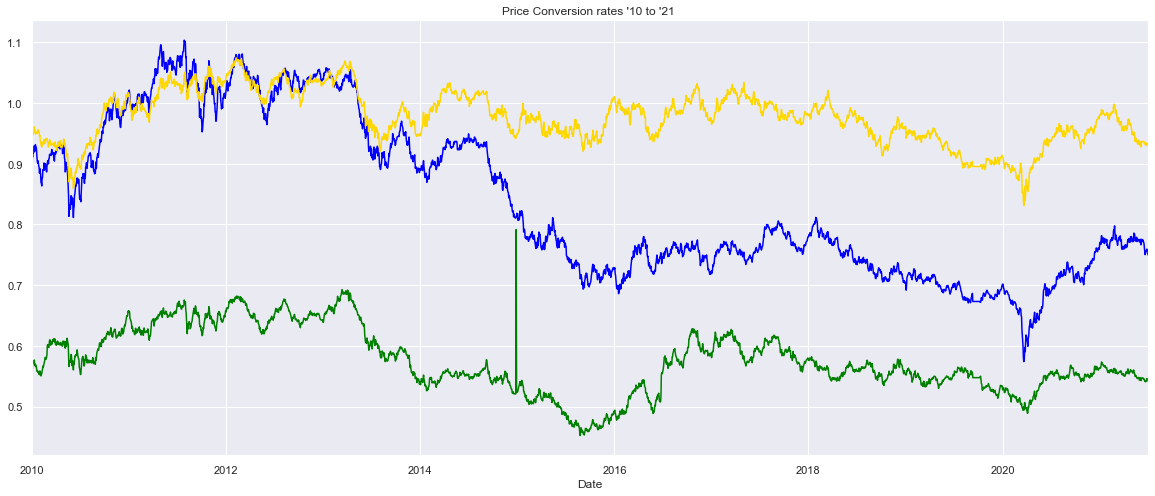

In [11]:
df_new["AUD_USD"][start_date:end_date].plot(figsize= (20,8), color = "blue")
df_new['AUD_GBP'][start_date:end_date].plot(color = "green")
df_new['AUD_CAD'][start_date:end_date].plot(color = "gold")
plt.title("Price Conversion rates '10 to '21 ")
plt.show()

viewing the plot with each time period having a different intensity of the initial colour

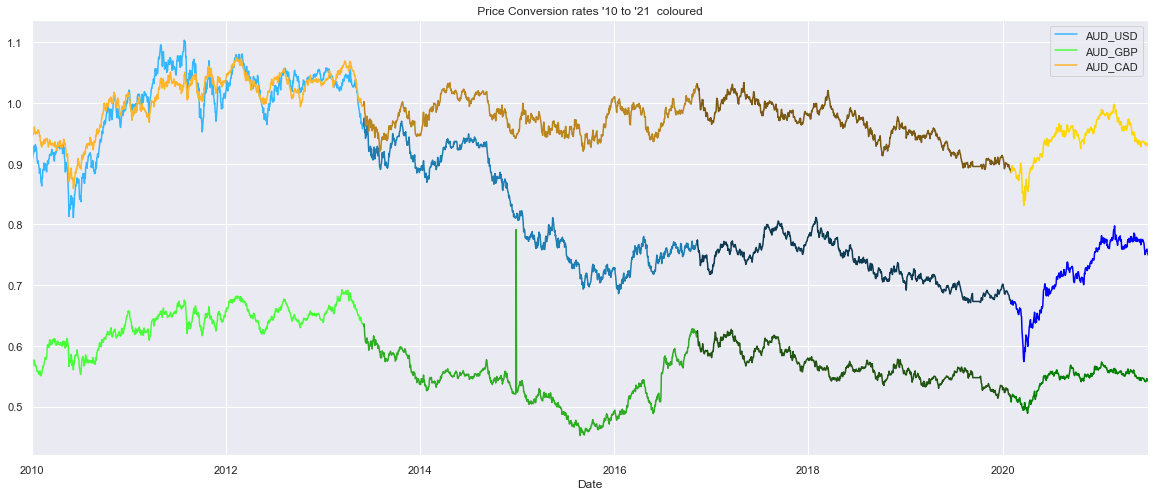

In [12]:
df_new['AUD_USD'][start_date:CAD_rc].plot(figsize= (20,8), color = "#33B8FF")
df_new['AUD_GBP'][start_date:CAD_rc].plot(color = "#49FF3A")
df_new['AUD_CAD'][start_date:CAD_rc].plot(color = "#FEB628")

df_new['AUD_USD'][CAD_rc:DT_election].plot(color = "#1E7EB2")
df_new['AUD_GBP'][CAD_rc:DT_election].plot(color = "#2FAB25")
df_new['AUD_CAD'][CAD_rc:DT_election].plot(color = "#BA861F")

df_new['AUD_USD'][DT_election:Brexit].plot(color = "#0E3A52")
df_new['AUD_GBP'][DT_election:Brexit].plot(color = "#225414")
df_new['AUD_CAD'][DT_election:Brexit].plot(color = "#7C5913")

df_new["AUD_USD"][Brexit:end_date].plot(color = "blue")
df_new['AUD_GBP'][Brexit:end_date].plot(color = "green")
df_new['AUD_CAD'][Brexit:end_date].plot(color = "gold")

plt.legend(['AUD_USD','AUD_GBP','AUD_CAD'])
plt.title(" Price Conversion rates '10 to '21  coloured ")
plt.show()

## Correlation

a better metric to see this stat would be the volume if we were handling corporate stocks but for this case stufy we'll stick to currency rates' conversion rates at Market day Close/end

In [13]:
print('Correlation among currency conversion rates from ' + str(start_date) + ' to ' + str(CAD_rc)+ '\n')
print('AUD_USD and AUD_GBP correlation: \t'+ str(df_new['AUD_USD'][start_date:CAD_rc].corr(df_new['AUD_GBP'][start_date:CAD_rc])))
print('AUD_GBP and AUD_CAD correlation: \t'+ str(df_new['AUD_GBP'][start_date:CAD_rc].corr(df_new['AUD_CAD'][start_date:CAD_rc])))

Correlation among currency conversion rates from 2010-01-01 to 2013-06-01

AUD_USD and AUD_GBP correlation: 	0.9043738359466068
AUD_GBP and AUD_CAD correlation: 	0.9182906778989981


note: displaying AUD_CAD to AUD_USD serves us no new analytical value and the correlation coefficient found is redundant and so it's skipped 

In [14]:
print('Correlation among currency conversion rates from ' + str(CAD_rc) + ' to ' + str(DT_election)+ '\n')
print('AUD_USD and AUD_GBP correlation: \t'+ str(df_new['AUD_USD'][CAD_rc:DT_election].corr(df_new['AUD_GBP'][CAD_rc:DT_election])))
print('AUD_GBP and AUD_CAD correlation: \t'+ str(df_new['AUD_GBP'][CAD_rc:DT_election].corr(df_new['AUD_CAD'][CAD_rc:DT_election])))

Correlation among currency conversion rates from 2013-06-01 to 2016-11-08

AUD_USD and AUD_GBP correlation: 	0.6494349148148175
AUD_GBP and AUD_CAD correlation: 	0.39367314765339456


In [15]:
print('Correlation among currency conversion rates from ' + str(DT_election) + ' to ' + str(Brexit)+ '\n')
print('AUD_USD and AUD_GBP correlation: \t'+ str(df_new['AUD_USD'][DT_election:Brexit].corr(df_new['AUD_GBP'][DT_election:Brexit])))
print('AUD_GBP and AUD_CAD correlation: \t'+ str(df_new['AUD_GBP'][DT_election:Brexit].corr(df_new['AUD_CAD'][DT_election:Brexit])))

Correlation among currency conversion rates from 2016-11-08 to 2020-01-31

AUD_USD and AUD_GBP correlation: 	0.7064171575722832
AUD_GBP and AUD_CAD correlation: 	0.7733844336151875


In [16]:
print('Correlation among currency conversion rates from ' + str(Brexit) + ' to ' + str(end_date)+ '\n')
print('AUD_USD and AUD_GBP correlation: \t'+ str(df_new['AUD_USD'][Brexit:end_date].corr(df_new['AUD_GBP'][Brexit:end_date])))
print('AUD_GBP and AUD_CAD correlation: \t'+ str(df_new['AUD_GBP'][Brexit:end_date].corr(df_new['AUD_CAD'][Brexit:end_date])))

Correlation among currency conversion rates from 2020-01-31 to 2021-07-01

AUD_USD and AUD_GBP correlation: 	0.8416054117387565
AUD_GBP and AUD_CAD correlation: 	0.9445920564296376


In [17]:
print('The overall Correlation among currency conversion rates from ' + str(start_date) + ' to ' + str(end_date)+ '\n')
print('AUD_USD and AUD_GBP correlation: \t'+ str(df_new['AUD_USD'][start_date:end_date].corr(df_new['AUD_GBP'][start_date:end_date])))
print('AUD_GBP and AUD_CAD correlation: \t'+ str(df_new['AUD_GBP'][start_date:end_date].corr(df_new['AUD_CAD'][start_date:end_date])))

The overall Correlation among currency conversion rates from 2010-01-01 to 2021-07-01

AUD_USD and AUD_GBP correlation: 	0.7856550068588397
AUD_GBP and AUD_CAD correlation: 	0.6716733298439067


## Fitting Models

### A basic analysis and model selection for AUD_CAD

In [18]:
size = int(len(df_new['AUD_CAD'])*0.8)
df_new_train = pd.DataFrame(index=df_new['AUD_CAD'].iloc[:size].index)
df_new_test = pd.DataFrame(index=df_new['AUD_CAD'].iloc[:size].index)
df_new_train['AUD_CAD'], df_new_test['AUD_CAD'] = df_new['AUD_CAD'].iloc[:size], df_new['AUD_CAD'].iloc[size:]
##exogenous variables split
df_new_train['AUD_USD'], df_new_test['AUD_USD'] = df_new['AUD_USD'].iloc[:size], df_new['AUD_USD'].iloc[size:]
df_new_train['AUD_GBP'], df_new_test['AUD_GBP'] = df_new['AUD_GBP'].iloc[:size], df_new['AUD_GBP'].iloc[size:]

In [19]:
def LLR_test(mod_1, mod_2, DF = 1):
    L1 = mod_1.fit(start_ar_lags = 11).llf
    L2 = mod_2.fit(start_ar_lags = 11).llf
    LR = (2*(L2-L1))    
    p = chi2.sf(LR, DF).round(3)
    return p

In [20]:
sts.adfuller(df_new_train['AUD_CAD'])

(-3.0386645315066665,
 0.031438009878346974,
 1,
 2398,
 {'1%': -3.4330799056770074,
  '5%': -2.8627460352798253,
  '10%': -2.5674120230995943},
 -18545.77795864901)

In [21]:
#the TS in question is stationary when taking the 5% significant benchmark from the ad fuller test

In [22]:
#fitting a simple ARIMAX (1,0,1) #no integration seems to be required since TS is assumed to be stationary
mod_cad_0=ARIMA(df_new_train['AUD_CAD'] , exog =df_new_train['AUD_USD'] , order=(1,0,1))

In [23]:
results_mod_cad_0 = mod_cad_0.fit()
results_mod_cad_0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                AUD_CAD   No. Observations:                 2400
Model:                     ARMA(1, 1)   Log Likelihood               10074.995
Method:                       css-mle   S.D. of innovations              0.004
Date:                Thu, 19 Aug 2021   AIC                         -20139.990
Time:                        21:28:14   BIC                         -20111.073
Sample:                    01-01-2010   HQIC                        -20129.470
                         - 03-14-2019                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.5203      0.029     17.910      0.000       0.463       0.577
AUD_USD           0.5346      0.012     43.045      0.000       0.510       0.559
ar.L1.AUD_CAD     0.9977      0.001    784.841      0.000       0.995       1.000
ma.L1.AUD_CAD    -0.0252      0.021     -1.181      0.238      -0.067       0.017
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0023           +0.0000j            1.0023            0.0000
MA.1           39.7129           +0.0000j           39.7129            0.0000
-----------------------------------------------------------------------------
"""

In [24]:
df_new_train["residuals_ARMAX1_1"]=results_mod_cad_0.resid
df_new_train.head()

,AUD_CAD,AUD_USD,AUD_GBP,residuals_ARMAX1_1
Date,,,,
2010-01-01,0.94512,0.898473,0.55510,-0.055477
2010-01-04,0.94940,0.912492,0.56619,-0.003349
2010-01-05,0.94730,0.911826,0.56980,-0.001963
2010-01-06,0.94900,0.920471,0.57422,-0.003110
2010-01-07,0.94870,0.917768,0.57592,0.000922


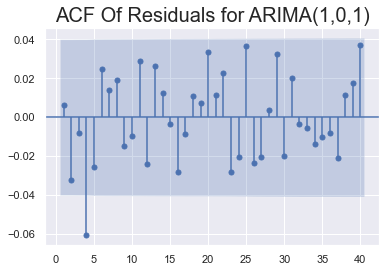

In [25]:
sgt.plot_acf(df_new_train.residuals_ARMAX1_1, zero = False, lags = 40)
plt.title("ACF Of Residuals for ARIMA(1,0,1)",size=20)
plt.show()
#we would expect it the result to be mostly insignificant lags that resemble white noise

In [26]:
model_ar_1_i_1_ma_2 = ARIMA(df_new_train['AUD_CAD'], exog =df_new_train['AUD_USD'],order=(1,1,2))
results_ar_1_i_1_ma_2 = model_ar_1_i_1_ma_2.fit()
model_ar_1_i_1_ma_3 = ARIMA(df_new_train['AUD_CAD'],exog =df_new_train['AUD_USD'], order=(1,1,3))
results_ar_1_i_1_ma_3 = model_ar_1_i_1_ma_3.fit()
model_ar_2_i_1_ma_1 = ARIMA(df_new_train['AUD_CAD'], exog =df_new_train['AUD_USD'],order=(2,1,1))
results_ar_2_i_1_ma_1 = model_ar_2_i_1_ma_1.fit()
model_ar_3_i_1_ma_1 = ARIMA(df_new_train['AUD_CAD'],exog =df_new_train['AUD_USD'], order=(3,1,1))
results_ar_3_i_1_ma_1 = model_ar_3_i_1_ma_1.fit()
model_ar_3_i_1_ma_2 = ARIMA(df_new_train['AUD_CAD'],exog =df_new_train['AUD_USD'], order=(3,1,2))
results_ar_3_i_1_ma_2 = model_ar_3_i_1_ma_2.fit(start_ar_lags=5)

In [27]:
print("ARIMAX(1,0,1):  \t LL = ", results_mod_cad_0.llf, "\t AIC = ", results_mod_cad_0.aic)
print("ARIMAX(1,1,2):  \t LL = ", results_ar_1_i_1_ma_2.llf, "\t AIC = ", results_ar_1_i_1_ma_2.aic)
print("ARIMAX(1,1,3):  \t LL = ", results_ar_1_i_1_ma_3.llf, "\t AIC = ", results_ar_1_i_1_ma_3.aic)
print("ARIMAX(2,1,1):  \t LL = ", results_ar_2_i_1_ma_1.llf, "\t AIC = ", results_ar_2_i_1_ma_1.aic)
print("ARIMAX(3,1,1):  \t LL = ", results_ar_3_i_1_ma_1.llf, "\t AIC = ", results_ar_3_i_1_ma_1.aic)
print("ARIMAX(3,1,2):  \t LL = ", results_ar_3_i_1_ma_2.llf, "\t AIC = ", results_ar_3_i_1_ma_2.aic)

ARIMAX(1,0,1):  	 LL =  10074.994760443557 	 AIC =  -20139.989520887113
ARIMAX(1,1,2):  	 LL =  9382.583687294496 	 AIC =  -18753.167374588993
ARIMAX(1,1,3):  	 LL =  9383.611051342905 	 AIC =  -18753.22210268581
ARIMAX(2,1,1):  	 LL =  9382.589213221701 	 AIC =  -18753.178426443403
ARIMAX(3,1,1):  	 LL =  9383.59918130506 	 AIC =  -18753.19836261012
ARIMAX(3,1,2):  	 LL =  9387.849542359316 	 AIC =  -18759.69908471863


In [28]:
#ARIMAX(1,0,1) and ARIMAX(3,1,2) seem to be in the lead with the highest LLR and lowest AIC, we run the Log likelihood test
#while keeping in mind a simpler model is always preferred to a more complex one if they give similer results (we want to avoid overfitting)
#
LLR_test(mod_cad_0,model_ar_3_i_1_ma_2, DF = 3)

1.0

In [29]:
#this result indicates that the simpler model was indeed a better fit for our Time series 
#observing it's residuals has already been done but let's checkout 3,1,2's just in case
df_new_train["residuals_ARMAX3_1_2"]=results_mod_cad_0.resid
df_new_train.head()

,AUD_CAD,AUD_USD,AUD_GBP,residuals_ARMAX1_1,residuals_ARMAX3_1_2
Date,,,,,
2010-01-01,0.94512,0.898473,0.55510,-0.055477,-0.055477
2010-01-04,0.94940,0.912492,0.56619,-0.003349,-0.003349
2010-01-05,0.94730,0.911826,0.56980,-0.001963,-0.001963
2010-01-06,0.94900,0.920471,0.57422,-0.003110,-0.003110
2010-01-07,0.94870,0.917768,0.57592,0.000922,0.000922


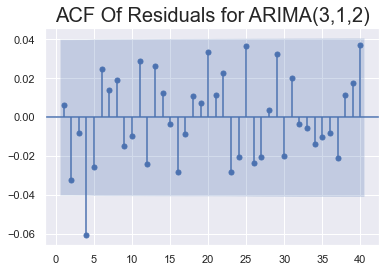

In [66]:
sgt.plot_acf(df_new_train.residuals_ARMAX3_1_2, zero = False, lags = 40)
plt.title("ACF Of Residuals for ARIMA(3,1,2)",size=20)
plt.show()
### incorporating 4 past lags can yield better results

In [31]:
# we'll do a seperate section for predictions

## Using auto_Arima method to generate the best fitting model (Out of bag estimator)

### For AUD_USD

In [32]:
#the seasonal component in our observations is the normal 5-day business week
mod_usd_1 = auto_arima(df_new['AUD_USD'][start_date:CAD_rc], exogenous = df_new[['AUD_GBP','AUD_CAD'] ][start_date:CAD_rc],
                            m = 5, max_p = 15, max_q = 12 ,information_criterion = 'oob',out_of_sample = int(len(df_new['AUD_USD'])*0.2))

In [33]:
mod_usd_2 = auto_arima(df_new['AUD_USD'][CAD_rc:DT_election], exogenous = df_new[['AUD_GBP','AUD_CAD'] ][CAD_rc:DT_election],
                            m = 5, max_p =15, max_q = 12, information_criterion = 'oob',out_of_sample = int(len(df_new['AUD_USD'])*0.2) )

In [34]:
mod_usd_3 = auto_arima(df_new['AUD_GBP'][DT_election:Brexit], exogenous = df_new[['AUD_GBP','AUD_CAD'] ][DT_election:Brexit],
                            m = 5, max_p = 15, max_q = 15 , information_criterion = 'oob',out_of_sample = int(len(df_new['AUD_USD'])*0.2)
                     , error_action ='trace' )
#upon closer inspection we can see that the best model could in fact be a simple polynomial or solved by linear regression 
#(i.e., differencing / integrating the time series has made it close to being perfectly constant).

ValueError: Could not successfully fit a viable ARIMA model to input data.
See http://alkaline-ml.com/pmdarima/no-successful-model.html for more information on why this can happen.

In [35]:
mod_usd_4 = auto_arima(df_new['AUD_USD'][Brexit:end_date], exogenous = df_new[['AUD_GBP','AUD_CAD'] ][Brexit:end_date],
                            m = 5, max_p = 15, max_q = 12 , information_criterion = 'oob',out_of_sample = int(len(df_new['AUD_USD'])*0.2))

In [36]:
print("\n model 1 \n", mod_usd_1.summary(),"\n model 2 \n",mod_usd_2.summary(),"\n model 3 is ignored \n","\n model 4 \n",mod_usd_4.summary())


 model 1 
                                SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  891
Model:               SARIMAX(0, 1, 1)   Log Likelihood                3562.470
Date:                Thu, 19 Aug 2021   AIC                          -7116.939
Time:                        21:29:10   BIC                          -7097.774
Sample:                    01-01-2010   HQIC                         -7109.614
                         - 05-31-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
AUD_GBP        0.9527      0.038     24.923      0.000       0.878       1.028
AUD_CAD        0.6386      0.035     18.421      0.000       0.571       0.706
ma.L1         -0.0715      0.035     -2.

### For AUD_GBP

In [37]:
#the seasonal component in our observations is the normal 5-day business week
mod_gbp_1 = auto_arima(df_new['AUD_GBP'][start_date:CAD_rc], exogenous = df_new[['AUD_USD','AUD_CAD'] ][start_date:CAD_rc],
                            m = 5, max_p = 15, max_q = 12 ,information_criterion = 'oob',out_of_sample = int(len(df_new['AUD_GBP'])*0.2))

In [38]:
mod_gbp_2 = auto_arima(df_new['AUD_GBP'][CAD_rc:DT_election], exogenous = df_new[['AUD_USD','AUD_CAD'] ][CAD_rc:DT_election],
                            m = 5, max_p =15, max_q = 12, information_criterion = 'oob',out_of_sample = int(len(df_new['AUD_GBP'])*0.2) )

In [39]:
mod_gbp_3 = auto_arima(df_new['AUD_GBP'][DT_election:Brexit], exogenous = df_new[['AUD_USD','AUD_CAD'] ][DT_election:Brexit],
                            m = 5, max_p = 15, max_q = 15 , information_criterion = 'oob',out_of_sample = int(len(df_new['AUD_GBP'])*0.2)
                     , error_action ='trace' )
#upon closer inspection we can see that the best model could in fact be a simple polynomial or solved by linear regression (i.e., differencing / integrating the time series has made it perfectly constant).

In [40]:
mod_gbp_4 = auto_arima(df_new['AUD_GBP'][Brexit:end_date], exogenous = df_new[['AUD_USD','AUD_CAD'] ][Brexit:end_date],
                            m = 5, max_p = 15, max_q = 12 , information_criterion = 'oob',out_of_sample = int(len(df_new['AUD_GBP'])*0.2))

In [41]:
print("\n model 1 \n", mod_gbp_1.summary(),"\n model 2 \n",mod_gbp_2.summary(),"\n model 3 \n" ,mod_gbp_3.summary(),"\n model 4 \n",mod_gbp_3.summary())


 model 1 
                                SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  891
Model:               SARIMAX(0, 1, 0)   Log Likelihood                4006.886
Date:                Thu, 19 Aug 2021   AIC                          -8007.772
Time:                        21:30:20   BIC                          -7993.398
Sample:                    01-01-2010   HQIC                         -8002.278
                         - 05-31-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
AUD_USD        0.3491      0.016     21.786      0.000       0.318       0.380
AUD_CAD        0.0755      0.025      3.001      0.003       0.026       0.125
sigma2      7.169e-06   2.82e-07     25.

## Predictions for the Future

### for AUD_CAD

In [42]:
results_mod_cad_0.predict()

Date
2010-01-01    1.000597
2010-01-04    0.952749
2010-01-05    0.949263
2010-01-06    0.952110
2010-01-07    0.947778
                ...   
2019-03-08    0.944339
2019-03-11    0.944870
2019-03-12    0.946281
2019-03-13    0.946785
2019-03-14    0.944583
Freq: B, Length: 2400, dtype: float64

In [43]:
df_pred_pr = pd.DataFrame( results_mod_cad_0.predict(), index = df_new[CAD_rc:DT_election].index)
df_pred_pr['predictions']=results_mod_cad_0.predict()

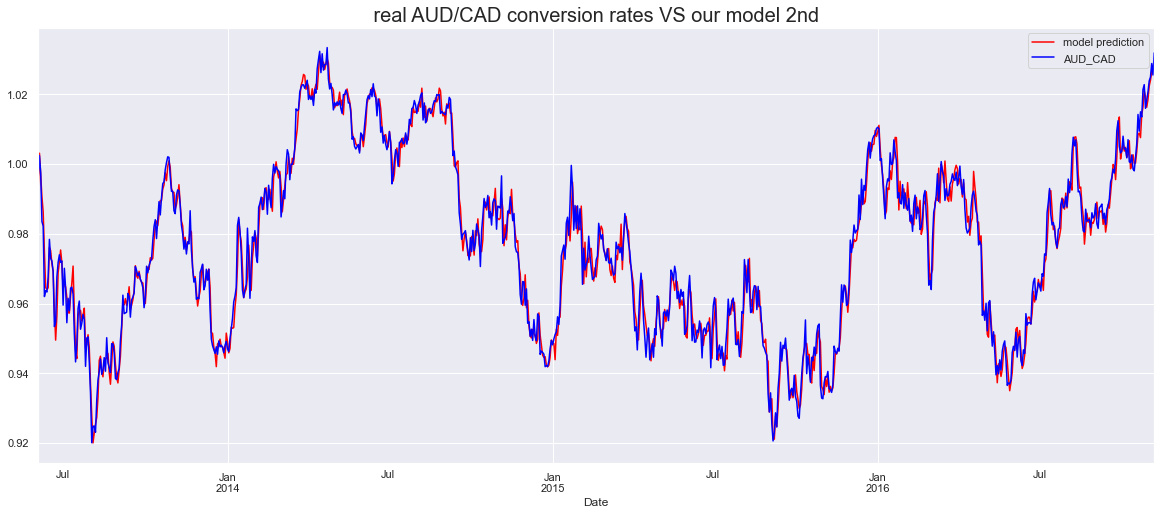

In [44]:
df_pred_pr['predictions'][CAD_rc:DT_election].plot(figsize = (20,8), color = "red")
df_new["AUD_CAD"][CAD_rc:DT_election].plot(color = "blue")
plt.title(" real AUD/CAD conversion rates VS our model 2nd ", size = 20)
plt.legend(['model prediction','AUD_CAD'])
plt.show()

### For AUD_USD

In [45]:
x=mod_usd_2.predict(n_periods=len(df_new[DT_election:Brexit]) , exogenous = df_new[['AUD_GBP','AUD_CAD']][DT_election:Brexit])

In [46]:
df_pred_pr2= pd.DataFrame( index = df_new[DT_election:Brexit].index)
df_pred_pr2['prediction']=x

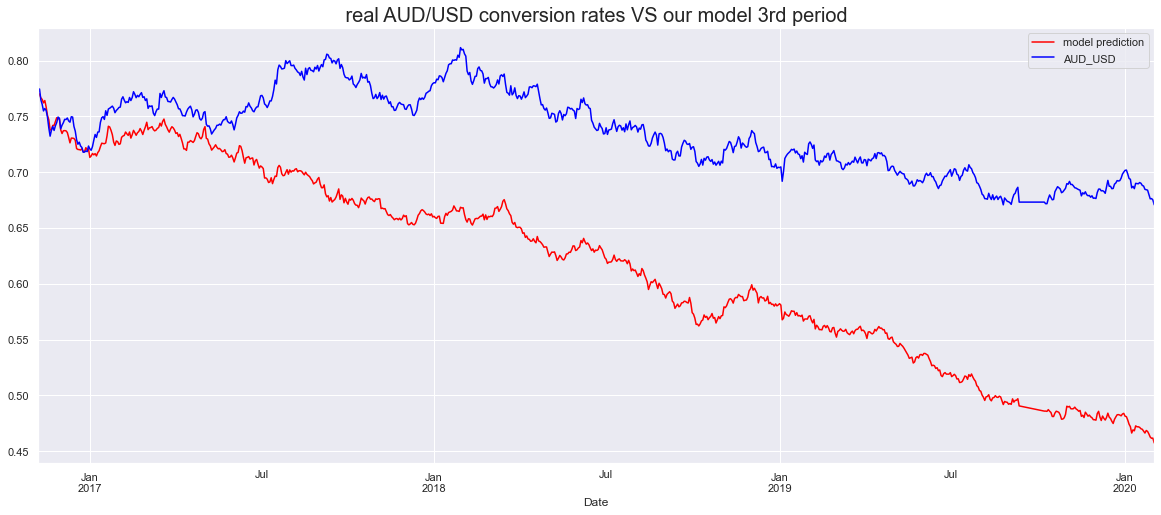

In [47]:
df_pred_pr2['prediction'][DT_election:Brexit].plot(figsize = (20,8), color = "red")
df_new['AUD_USD'][DT_election:Brexit].plot(color = "blue")
plt.title(" real AUD/USD conversion rates VS our model 3rd period ", size = 20)
plt.legend(['model prediction','AUD_USD'])
plt.show()

### For AUD_GBP

In [48]:
x=mod_gbp_3.predict(n_periods=len(df_new[Brexit:end_date]) , exogenous = df_new[['AUD_USD','AUD_CAD']][Brexit:end_date])

In [64]:
df_pred_pr3= pd.DataFrame( index = df_new[Brexit:end_date].index)
df_pred_pr3['prediction']=x
df_pred_pr3

,prediction
Date,
2020-01-31,0.512440
2020-02-03,0.511955
2020-02-04,0.512232
2020-02-05,0.514441
2020-02-06,0.515573
...,...
2021-06-25,0.552808
2021-06-28,0.553144
2021-06-29,0.552170


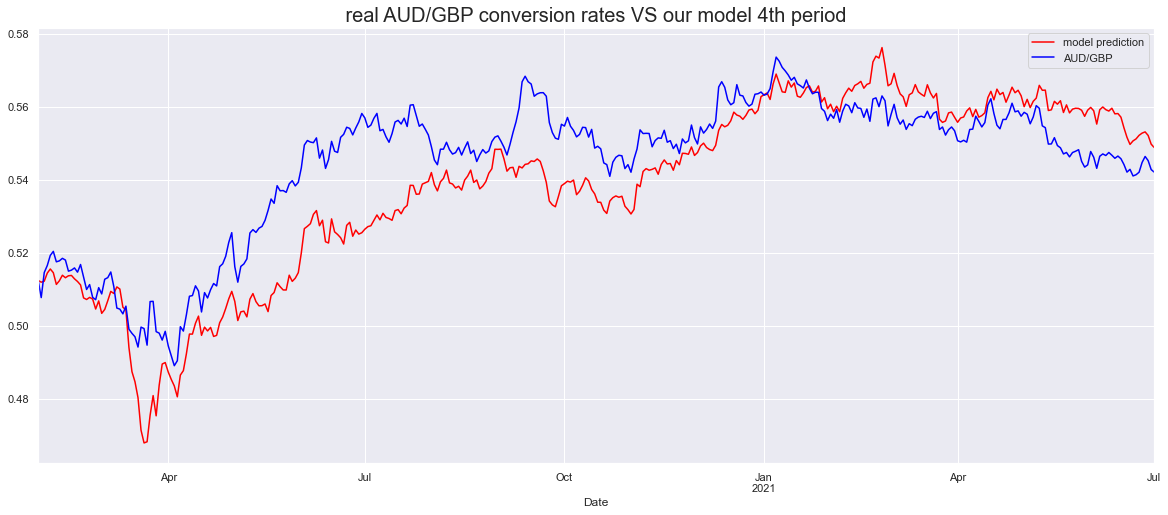

In [65]:
%matplotlib inline
df_pred_pr3['prediction'].plot(figsize=(20,8) , color = "red")
df_new['AUD_GBP'][Brexit:end_date].plot(color = "blue")
plt.title(" real AUD/GBP conversion rates VS our model 4th period ", size = 20)
plt.legend(['model prediction','AUD/GBP'])
plt.show()

## A word for Conclusion:

Observations:


-We saw how overfitting a model to a dataset performs poorly and backfires accuracy wise. 
The truth is that the future is unpredictable and while we can improve our forecast by adding exogenous variable that describe the entropy and political/social decisions that are being made everyday that change  the potential outcome of a certain currency but there's a finite limit to what we can add to a single model and the truth is often the simplest and most straightforward (overparametrazation if it doesn't SIGNIFICANTLY improve the results is often misguiding).


-we didn't need to rely of forced integration or use of returns (which are more appropriate in a  context of corporate stocks than exchange rates) as the values were already extremly close to an (almost) constant mean thoughout our periods.


-the point of calculating squared returns was to include it in the volatility study but i decided to do it in it's own notebook


-The choice of the out of bag Criterion was because in the previous case study I saw while learning this the generalized AIC was used , I thought i'd toy around with the code and see if different models performed better according to different criterion (Duh !) but my theoritical background on Time-Series needs more work but I'm proud of reaching the end of this notebook.


-I didn't plot the prediction for all 9 models as it would get redundant and people would miss the point:
our models worked and predicted prices and shocks (admittedly the shocks would go beyond our expectations and that's maybe due to volatility clustering where a high volatility period is followed by more high volatility periods and as such for low volatility ones)(Bearish trends have their own stronger bias compared to selling ones)

-The choice of key dates was a personal attempt to subdivide the 11 year period , I'm sure real analysts and historians would find better compelling turning points in recent economy history but this was simply a personal choice and not for you to overthink

Roadmap:
I will continue the study of Time series but next time working on the Chia Cryptocurrency and focusing on analyzing it's volatility and forcing the stationarity Via working with returns as it's a promising new crypto that brings hope for more environmentally friendly mining and lower electricity bills for both individuals and whale miners as well as cheaper GPUs as mining can be done off of plotting Hard Drives instead.